# MIES data
This notebook contains the analyses on the MIES (Multidimensional Introversion-Extraversion Scales) data reported in the paper.
Data are downloaded from Open Psychometrics, and can be found here: https://openpsychometrics.org/_rawdata/. <br>
This dataset includes ~7000 participants, and it reports their answers (Likert scale) on a ~90 questionnaire items, as well as a self-reported introversion/extraversion score (binary, but coded as 0/1 in the dataset). For simplicitly, we only included participants who classified themselves as extrovert or introvert, excluding those that chose the neutral option on the self-assessed introversion/extraversion question.


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_validate

# Load and process data

In [2]:
df = pd.read_csv('mies_data/data.csv', sep='\t')

In [3]:
df_subs = df[[c for c in df.columns if (c.endswith('A')) or (c == 'IE')]]
df_subs = df_subs[df_subs['IE'] != 3]
df_subs['IE'] = df_subs['IE'].map({1:0, 2:1})

Display a sample of the data. All columns starting with Q report answers to questionnaire items, while 'IE' is the self-reported score.

In [4]:
df_subs.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q83A,Q84A,Q85A,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A,IE
1,5,5,1,5,2,2,5,2,1,3,...,2,2,2,1,3,4,4,4,3,1.0
2,3,4,5,3,4,5,5,5,5,5,...,5,5,5,4,5,3,2,1,1,0.0
3,5,2,1,1,5,5,5,4,4,2,...,5,5,5,3,5,4,4,3,3,0.0
4,1,2,1,1,3,3,5,1,3,4,...,3,1,1,3,1,2,5,5,5,1.0
5,2,5,5,1,2,4,5,2,4,4,...,2,3,1,3,1,2,2,2,2,0.0


## Fit cross-validated models
We fit 10-fold logistic regression models iteratively, varying the number of (randomly sampled) datapoints that go into the analysis. Models use all questionnaire items as predictors, and the self-reported introversion/extraversion scores as outcome variable.

In [5]:
K = 10
gkfolds = KFold(n_splits=K)

In [6]:
est_log = LogisticRegression()
sizes = [50, 100, 500, 1000, 5000, df_subs.shape[0]]
cv_mean_r2, cv_mean_r2_train = [], []

for sz in sizes:
    np.random.seed(0)
    ridx = np.random.randint(0, df_subs.shape[0], sz)
    subdf = df_subs.iloc[ridx, :].dropna()
    # split data
    X = subdf[[c for c in subdf.columns if c != 'IE']].values
    y = subdf['IE'].values
    cv_scores = cross_validate(est_log, X, y, cv=gkfolds, return_train_score=True)
    # store scores
    mean_r2 = cv_scores['test_score'].mean()
    mean_r2_train = cv_scores['train_score'].mean()
    cv_mean_r2.append(mean_r2)
    cv_mean_r2_train.append(mean_r2_train)

## Performance by sample size

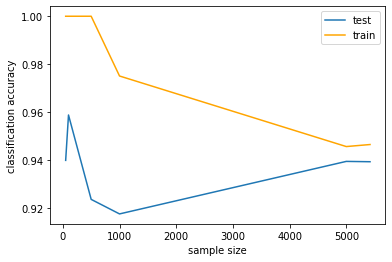

In [7]:
sns.lineplot(sizes, cv_mean_r2, label='test')
sns.lineplot(sizes, cv_mean_r2_train, color='orange', label='train')
plt.xlabel('sample size')
plt.ylabel('classification accuracy')
plt.show()

## Performance/complexity trade-off
Here, we iteratively fit CV models using all samples, but **varying the number of dictionary items used as predictors**. <br>
Classification performance steadily increases up to around 20 features, with a more than .10 gain between 1 and 20 features.
This shows that increasing model complexity (and thus reducing direct interpretability of model parameters) can yield significant improvements in predictive performance. <br> 
There is often a trade-off between complexity and accuracy, where significant performance differences are at stake. Enforcing simple models (as often done in psychology to ensure straightforward interpretability) can thus come at a significant cost.

In [8]:
feats = [1, 5, 10, 15, 20, 30, 40, 50, df_subs.shape[1]-1]
cv_mean_r2, cv_mean_r2_train = [], []

for f in feats:
    subdf = df_subs.dropna()
    X = subdf.iloc[:,:f].values
    y = subdf['IE'].values
    
    cv_scores = cross_validate(est_log, X, y, cv=gkfolds, return_train_score=True)
    mean_r2 = cv_scores['test_score'].mean()
    mean_r2_train = cv_scores['train_score'].mean()

    cv_mean_r2.append(mean_r2)
    cv_mean_r2_train.append(mean_r2_train)

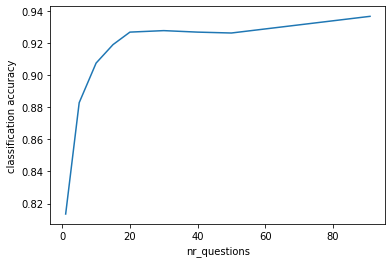

In [9]:
sns.lineplot(feats, cv_mean_r2)
plt.xlabel('nr_questions')
plt.ylabel('classification accuracy')
plt.show()

## Interpreting internal parameters: LASSO vs. Ridge
In psychology, inference on mechanisms underlying phenomena is often drawn by interpreting parameter estimates for features of interest (and their significance) in causal terms. However, direct interpretation of parameter estimates can be misleading. Models using the same input features (but, for example, differring in optimization strategies or other aspects of parameter estimation) can achieve the same performance levels but attribute different weights to the various input features. <br>
One example of this are widely used regularization methods for regression: LASSO and ridge regression. These two methods are generally used in high-dimensional settings to prevent overfitting. Both methods do so by reducing variance and in both cases, this is achieved by adding a term is added to the loss function which penalizes models with large parameter estimates. Across the two methods, however, the penalty term differs. In practice, regression with LASSO penalty regularizes by forcing parameter estimates to zero, effectively corresponding to a feature selection method, while this is not the case in ridge regression. <br>
Often, (with adequate tuning of the regularization parameters alpha), the two methods yield comparable performance. Due to the nature of the regularization imposed to the model, however, parameter estimates differ (sometimes widely). In most cases there is no intrinsic reason to claim that one is most suited to modeling a certain phenomenon than the other: estimates produced by either model are thus equally "valid". This suggests that directly interpreting individual parameter estimates in terms of how strongly a certain feature influences the outcome variable can be tricky: estimates are conditional on which model is used, and different configurations of parameter estimates could model a certain phenomenon equally well.

In this section, we demonstrate these points by fitting LASSO and ridge regression models to the MIES data, and inspecting the resulting model coefficients.

In [72]:
np.random.seed(0)
test_size = round(subdf.shape[0]/ 100 * 70)
train_idx = np.random.randint(0, subdf.shape[0], test_size)
test_idx = list(set(range(0, subdf.shape[0])) - set(train_idx))
X = subdf.iloc[train_idx,:subdf.shape[1]-1].values
y = subdf['IE'].values[train_idx]
X_test = subdf.iloc[test_idx,:subdf.shape[1]-1].values
y_test = subdf['IE'].values[test_idx]


Using LassoCV from sklearn to tune the regularization parameter alpha based on performance of different alphas in cross-validated regression. <br> Note that here, to simplify things, we treat the outcome variable as a numerical variable (which only takes zero and one as value). <br>
LassoCV also automatically computes model coefficients based on performance across validation sets.

In [73]:
lasso_est = LassoCV(random_state=0, n_alphas=11).fit(X, y)
lasso_coefs = lasso_est.coef_
lasso_alpha = lasso_est.alpha_
mse_lasso = lasso_est.mse_path_[np.where(lasso_est.alphas_ == lasso_alpha)[0][0]].mean()

In [74]:
print(f'Lasso mse: {mse_lasso}')
print(f'Lasso alpha: {lasso_alpha}')

Lasso mse: 0.06171160888585714
Lasso alpha: 0.002638389555679271


The best-performing model has an alpha of ~.003 and a mean squared error of .065.
Let's now tune alpha for ridge regression. 
NB:
- We use leave-one-out cross-validation both here and for LASSO: there seem to be some inconsistencies in RidgeCV, such that if one gives custom folds as inputs, there is no way to retrieve cross-validation scores.
- We specify custom alphas, the grid used by RidgeCV is pretty weird.


In [75]:
ridge_est = RidgeCV(alphas=[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 100, 1000], 
                    store_cv_values=True).fit(X, y)
ridge_coefs = ridge_est.coef_

Here, we have to manually compute the best alpha and the error associated with it based on the performance matrix (alphas x folds).

In [76]:
errors = []
for i in range(ridge_est.cv_values_.shape[1]):
    err = ridge_est.cv_values_[:, i].mean()
    errors.append(err)
    if max(errors) == err:
        min_mse = err
        ridge_alpha = ridge_est.alphas[i]

In [77]:
print(f'Ridge mse: {min_mse}')
print(f'Ridge alpha: {ridge_alpha}')

Ridge mse: 0.061653978465472506
Ridge alpha: 1e-15


Check performance of the models on the test set

In [78]:
print(f'LASSO R2 on test set: {lasso_est.score(X_test, y_test)}')
print(f'Ridge R2 on test set {ridge_est.score(X_test, y_test)}')

LASSO R2 on test set: 0.5640494047109487
Ridge R2 on test set 0.5634742084965249


In [79]:
print(f'LASSO MSE on test set: {np.power(lasso_est.predict(X_test) - y_test, 2).mean()})')
print(f'Ridge MSE on test set: {np.power(ridge_est.predict(X_test) - y_test, 2).mean()}')

LASSO MSE on test set: 0.06643979958423482)
Ridge MSE on test set: 0.06652746071286016


The best-performing model has an alpha of 1e-15, and its average MSE is 0.065, that is, comparable to that achieved by the best LASSO.
We now have two models with practically identical MSE, same input features, differing only in the penalty term of their loss function. <br> 
Let's visualize and compare **parameter estimates**.

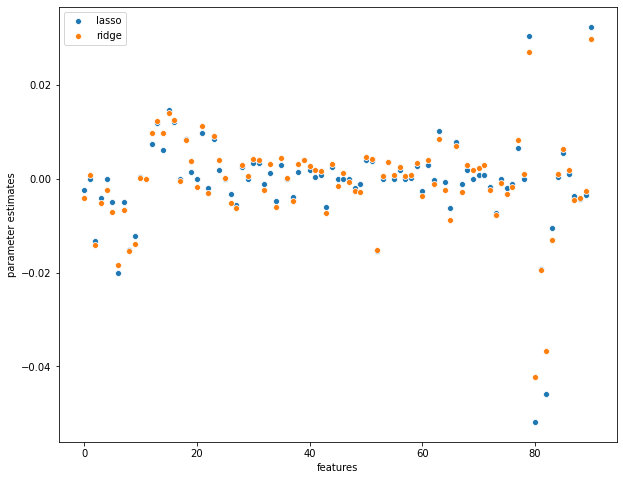

In [80]:
plt.figure(figsize=(10,8))
sns.scatterplot(range(X.shape[1]), lasso_coefs, label='lasso')
sns.scatterplot(range(X.shape[1]), ridge_coefs, label='ridge')
plt.xlabel('features')
plt.ylabel('parameter estimates')
plt.show()

As the plot shows, many LASSO features are shrunk to zero, while the corresponding features in ridge regression have non-zero coefficients, which changes their **"causal" interpretation** even qualitatively (no effect vs. some effect). Despite similar performance, the overall pattern of coefficients is similar but far from identical across the two models (many feature weights differ). Causal interpretations of individual parameters should thus be taken with a grain of salt. More generally, **interpretability** as direct causal interpretability of individual estimates may not be as necessary and reliable for scientific models as often claimed (or assumed) in psychology. 

In [52]:
cl_ridge = [int(i) for i in ridge_est.predict(X_test) > .5]
cl_lasso = [int(i) for i in lasso_est.predict(X_test) > .5]

In [53]:
print(f'Ridge classification accuracy: {(y_test == cl_ridge).sum() / (y_test == cl_ridge).shape[0]}')
print(f'Lasso classification accuracy: {(y_test == cl_lasso).sum() / (y_test == cl_lasso).shape[0]}')

Ridge classification accuracy: 0.9357076780758556
Lasso classification accuracy: 0.9327012025901943
